# Base Ireland
Focus on minimal case dataset.

* date

* country
* country_code
* country_id

* continent
* region -- sub-contintent but larger than country
* province

* new_cases
* new_deaths
* new_tests


In [64]:
from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
%matplotlib inline

# Params

In [65]:
# At: https://data.gov.ie/dataset/covid19countystatisticshpscireland
ireland_dataset = 'http://opendata-geohive.hub.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}'
base_ireland_dataset = '../../data/base_ireland.pkl'

# The columns used in the base representation
base_cols = [
    'date', 'country', 'country_code', 'country_id', 'continent', 'region', 'county', 'province',
    'new_cases', 'new_deaths', 
    'population'
]


# The Ireland Dataset

## Load the Ireland Dataset 

In [66]:
logger.info('Loading Ireland dataset @ %s' % ireland_dataset)

ireland = pd.read_csv(ireland_dataset, parse_dates=['TimeStamp'], low_memory=False)
ireland.shape, ireland['CountyName'].nunique(), ireland.columns, ireland['TimeStamp'].max()

2020-09-16 22:31:25.861 | INFO     | __main__:<module>:1 - Loading Ireland dataset @ http://opendata-geohive.hub.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}


((5174, 16),
 26,
 Index(['OBJECTID', 'ORIGID', 'CountyName', 'PopulationCensus16', 'TimeStamp',
        'IGEasting', 'IGNorthing', 'Lat', 'Long', 'UGI', 'ConfirmedCovidCases',
        'PopulationProportionCovidCases', 'ConfirmedCovidDeaths',
        'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length'],
       dtype='object'),
 Timestamp('2020-09-14 00:00:00+0000', tz='UTC'))

In [67]:
ireland = ireland.rename(columns={
    'CountyName': 'county',
    'PopulationCensus16': 'population',
    'TimeStamp': 'date',
    'ConfirmedCovidCases': 'cum_cases',
    'ConfirmedCovidDeaths': 'cum_deaths'
})

ireland['date'] = ireland['date'].map(
    lambda date: date.to_pydatetime())

ireland.head()

,OBJECTID,ORIGID,county,population,date,IGEasting,IGNorthing,Lat,Long,UGI,cum_cases,PopulationProportionCovidCases,cum_deaths,ConfirmedCovidRecovered,Shape__Area,Shape__Length
0,1,1,Carlow,56932,2020-02-27 00:00:00+00:00,278661,163444,52.7168,-6.8367,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,2.432352e+09,3.193486e+05
1,2,2,Cavan,76176,2020-02-27 00:00:00+00:00,246380,304501,53.9878,-7.2937,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,5.575010e+09,5.159545e+05
2,3,3,Clare,118817,2020-02-27 00:00:00+00:00,133493,182732,52.8917,-8.9889,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,8.722542e+09,1.013949e+06
3,4,4,Cork,542868,2020-02-27 00:00:00+00:00,156242,77860,51.9517,-8.6372,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.952949e+10,2.129949e+06
4,5,5,Donegal,159192,2020-02-27 00:00:00+00:00,202615,405691,54.8989,-7.9600,http://data.geohive.ie/resource/county/2ae1962...,0,NaN,NaN,NaN,1.462404e+10,2.145086e+06


# New Cases/Deaths

In [68]:
new_cases_deaths = ireland.groupby('county').apply(
    lambda g: g.set_index('date')[['cum_cases', 'cum_deaths']]\
        .diff()\
        .fillna(g.set_index('date')[['cum_cases', 'cum_deaths']])).rename(columns={
    'cum_cases': 'new_cases',
    'cum_deaths': 'new_deaths'
})

ireland = ireland.set_index(['county', 'date']).join(new_cases_deaths).reset_index()

ireland.tail()

,county,date,OBJECTID,ORIGID,population,IGEasting,IGNorthing,Lat,Long,UGI,cum_cases,PopulationProportionCovidCases,cum_deaths,ConfirmedCovidRecovered,Shape__Area,Shape__Length,new_cases,new_deaths
5169,Tipperary,2020-09-14 00:00:00+00:00,5170,22,159553,205427,154345,52.6407,-7.9206,http://data.geohive.ie/resource/county/2ae1962...,748,468.809737,NaN,NaN,1.155120e+10,781276.579658,5.0,NaN
5170,Waterford,2020-09-14 00:00:00+00:00,5171,23,116176,234676,105809,52.2035,-7.4935,http://data.geohive.ie/resource/county/2ae1962...,271,233.266768,NaN,NaN,4.848380e+09,643184.903993,11.0,NaN
5171,Westmeath,2020-09-14 00:00:00+00:00,5172,24,88770,238362,255966,53.5524,-7.4219,http://data.geohive.ie/resource/county/2ae1962...,731,823.476400,NaN,NaN,5.208706e+09,422669.332716,10.0,NaN
5172,Wexford,2020-09-14 00:00:00+00:00,5173,25,149722,301627,141559,52.5164,-6.5037,http://data.geohive.ie/resource/county/2ae1962...,346,231.094963,NaN,NaN,6.332221e+09,589324.476745,5.0,NaN
5173,Wicklow,2020-09-14 00:00:00+00:00,5174,26,142425,311162,197894,53.0205,-6.3442,http://data.geohive.ie/resource/county/2ae1962...,812,570.124627,NaN,NaN,5.580729e+09,427539.198567,7.0,NaN


# Add Provinces

In [69]:
provinces = {
    'Galway': 'Connaught', 'Leitrim': 'Connaught', 'Mayo': 'Connaught', 
    'Roscommon': 'Connaught', 'Sligo': 'Connaught',
 
    'Carlow': 'Leinster', 'Dublin': 'Leinster', 'Kildare': 'Leinster', 
    'Kilkenny': 'Leinster', 'Laois': 'Leinster', 'Longford': 'Leinster', 
    'Louth': 'Leinster', 'Meath': 'Leinster', 'Offaly': 'Leinster', 
    'Westmeath': 'Leinster', 'Wexford': 'Leinster', 'Wicklow': 'Leinster',
    
    'Clare': 'Munster', 'Cork': 'Munster', 'Kerry': 'Munster', 
    'Limerick': 'Munster', 'Tipperary': 'Munster', 'Waterford': 'Munster',

    'Cavan': 'Ulster', 'Donegal': 'Ulster', 'Monaghan': 'Ulster', 
}

ireland['province'] = ireland['county'].map(lambda name: provinces[name])

ireland['province'].unique(), ireland['province'].nunique()



(array(['Leinster', 'Ulster', 'Munster', 'Connaught'], dtype=object), 4)

# Save Dataset

In [70]:
ireland['country'] = 'Ireland'
ireland['country_code'] = 'IRL'
ireland['country_id'] = 'IE'
ireland['continent'] = 'Europe'
ireland['region'] = 'eu'

In [71]:
ireland_base = ireland[base_cols].copy()
ireland_base.shape, ireland_base['county'].nunique()

((5174, 11), 26)

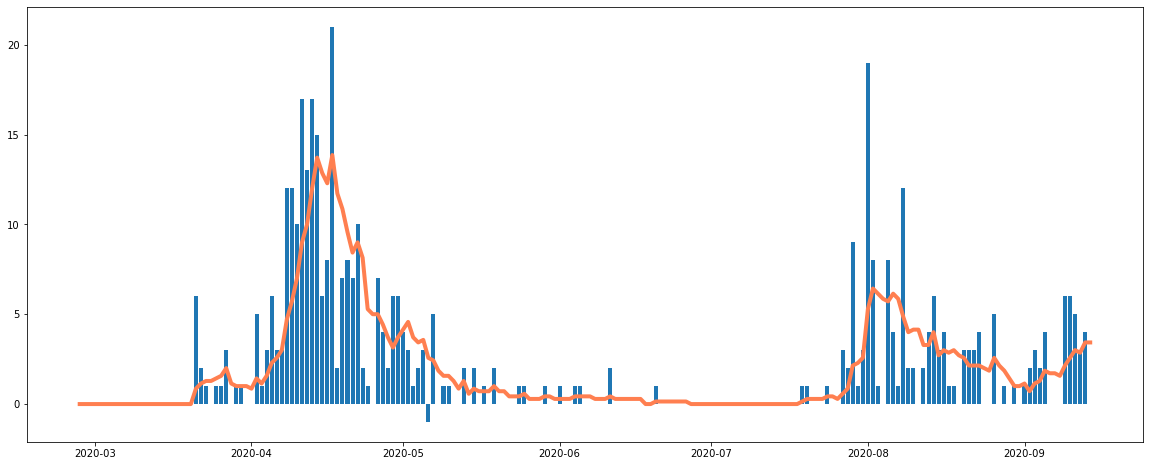

In [72]:
fig, ax = plt.subplots(figsize=(20, 8))

county = 'Laois'
x = ireland_base[ireland_base['county']==county].set_index('date').index
y = ireland_base[ireland_base['county']==county].set_index('date')['new_cases']

ax.bar(x, y)
ax.plot(x, y.rolling('7d').mean(), c='coral', lw=4)

In [73]:
logger.info('Saving base Ireland dataset --> %s' % base_ireland_dataset)

ireland_base.to_pickle(base_ireland_dataset)
ireland_base.shape, ireland_base.date.max()

2020-09-16 22:31:32.598 | INFO     | __main__:<module>:1 - Saving base Ireland dataset --> ../../data/base_ireland.pkl


((5174, 11), Timestamp('2020-09-14 00:00:00+0000', tz='UTC'))

In [74]:
ireland_base

,date,country,country_code,country_id,continent,region,county,province,new_cases,new_deaths,population
0,2020-02-27 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Carlow,Leinster,0.0,NaN,56932
1,2020-02-27 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Cavan,Ulster,0.0,NaN,76176
2,2020-02-27 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Clare,Munster,0.0,NaN,118817
3,2020-02-27 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Cork,Munster,0.0,NaN,542868
4,2020-02-27 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Donegal,Ulster,0.0,NaN,159192
...,...,...,...,...,...,...,...,...,...,...,...
5169,2020-09-14 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Tipperary,Munster,5.0,NaN,159553
5170,2020-09-14 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Waterford,Munster,11.0,NaN,116176
5171,2020-09-14 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Westmeath,Leinster,10.0,NaN,88770
5172,2020-09-14 00:00:00+00:00,Ireland,IRL,IE,Europe,eu,Wexford,Leinster,5.0,NaN,149722
